In [138]:
import os
import xarray as xr
import cartopy as cp
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.filterwarnings("ignore")

In [140]:
# specify path to data
path = '/Users/jonniebarnsley/Documents/Climate/Data/CORDEX'

In [128]:
class Ensemble():

    '''Ensemble class to store, navigate, and plot climate model ensemble data'''

    def __init__(self):
        self.data = []

    def add_data(self, file):
        self.data.append(file)

    def info(self):

        '''
        
        Prints helpful information about the Ensemble including:
         - Ensemble size: how many datasets exist within the ensemble
         - Variables: eg. tas, sst
         - Experiments: e.g. historical, rcp26, rcp85
         - Driving models: The boundary condition GCMs e.g. MOHC-HadGEM2-ES
         - Regional climate models: e.g. MOHC-HadREM3-GA7-05
            
            '''

        uninteresting_vars = [  'rlat_bnds',
                                'rlon_bnds',
                                'rotated_latitude_longitude',
                                'time_bnds',
                                'vertices_latitude',
                                'vertices_longitude'
                                ]
        experiments = set()
        variables = set()
        gcms = set()
        rcms = set()
        for file in self.data:
            experiments.add(file.experiment_id)
            gcms.add(file.driving_model_id)
            rcms.add(file.model_id)
            for var in file.data_vars:
                if var not in uninteresting_vars:
                    variables.add(var)
        
        print('Ensemble of size:', len(self.data))
        print('Variables:', *variables)
        print('Experiments:', *experiments)
        print('Driving models:', *gcms)
        print('Regional climate models:', *rcms)
  
    def filter(self, experiment_id=None, variable_id=None, gcm_id=None, rcm_id=None):
        
        '''
        
        Returns a smaller ensemble, a subset of the original ensemble, which meets criteria
        specified in the parameters:
         - experiment_id e.g. rcp26
         - variable_id e.g. tas
         - gcm_id e.g. MOHC-HadGEM2-ES
         - rcm_id e.g. MOHC-HadREM3-GA7-05
         
         '''

        output = Ensemble()
        for file in self.data:
            if experiment_id and file.experiment_id != experiment_id:
                continue
            if variable_id and not variable_id in file.variables:
                continue
            if gcm_id and file.driving_model_id != gcm_id:
                continue
            if rcm_id and file.model_id != rcm_id:
                continue
            output.add_data(file)

        if len(output.data) == 0:
            raise KeyError('Oh no! There\'s no data that matches these criteria!')
        else:
            return output


In [139]:
# load data into Ensemble class

CORDEX = Ensemble()

variables = ['tas']
experiments = ['historical', 'rcp26', 'rcp85']

for variable, experiment in product(variables, experiments):
    filenames = os.listdir(f'{path}/{variable}/{experiment}')
    file_paths = [f'{path}/{variable}/{experiment}/{filename}' for filename in filenames if '.nc' in filename]
    file = xr.open_mfdataset(file_paths)
    CORDEX.add_data(file)

CORDEX.info()

Ensemble of size: 3
Variables: tas
Experiments: rcp26 historical rcp85
Driving models: MOHC-HadGEM2-ES
Regional climate models: MOHC-HadREM3-GA7-05


In [117]:
# navigate through Ensemble

rcp26 = CORDEX.filter(experiment_id='rcp26')
rcp26.info()

Ensemble of size: 1
Variables: tas
Experiments: rcp26
Driving models: MOHC-HadGEM2-ES
Regional climate models: MOHC-HadREM3-GA7-05


In [118]:
# identify file of interest

file = rcp26.data[0]
file

<xarray.Dataset>
Dimensions:                     (rlat: 412, rlon: 424, time: 1129, bnds: 2, vertices: 4)
Coordinates:
    height                      float64 1.5
    latitude                    (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    longitude                   (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat                        (rlat) float64 -23.37 -23.26 ... 21.73 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.15
  * time                        (time) object 2005-12-16 00:00:00 ... 2099-12...
Dimensions without coordinates: bnds, vertices
Data variables:
    rlat_bnds                   (time, rlat, bnds) float64 dask.array<chunksize=(61, 412, 2), meta=np.ndarray>
    rlon_bnds                   (time, rlon, bnds) float64 dask.array<chunksize=(61, 424, 2), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(61, 412, 424), meta=np.ndarray>
    time_bnds                   (time, bnds) object dask.array<chunksize=(61, 2), meta=np.ndarray>
    vertices_latitude           (time, rlat, rlon, vertices) float64 dask.array<chunksize=(61, 412, 424, 4), meta=np.ndarray>
    vertices_longitude          (time, rlat, rlon, vertices) float64 dask.array<chunksize=(61, 412, 424, 4), meta=np.ndarray>
Attributes: (12/20)
    model_id:                       MOHC-HadREM3-GA7-05
    driving_experiment_name:        rcp26
    creation_date:                  2020-11-20T09:21:23Z
    project_id:                     CORDEX
    experiment:                     rcp26 run using HadGEM2-ES as a driving m...
    institution:                    MetOffice, Hadley Centre, UK
    ...                             ...
    rcm_version_id:                 v1
    c3s_disclaimer:                 This data has been produced in the contex...
    driving_model_id:               MOHC-HadGEM2-ES
    tracking_id:                    hdl:21.14103/6a6a35ea-907a-4391-adf1-2d25...
    institute_id:                   MOHC
    frequency:                      mon

In [120]:
# Process data for spatial plot

tas = file.tas-273.15 #kelvin to C
lat = file.latitude
lon = file.longitude

rcp26_eoc = tas.sel(time = slice('2080-01-01', '2099-12-30')).mean(dim = 'time') #end of century

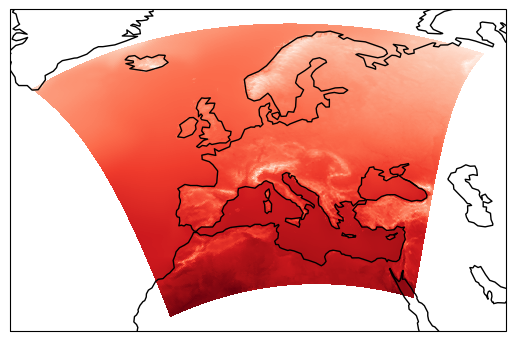

In [121]:
#example spatial plot
fig = plt.figure()
ax = plt.axes(projection = cp.crs.Robinson())

Reds = plt.get_cmap('Reds')

ax.pcolormesh(lon, lat, rcp26_eoc, transform = cp.crs.PlateCarree(), cmap = Reds)
ax.coastlines()


In [122]:
# Process data for timeseries plot

pyrenees_ts = tas.sel(  rlon = slice(-14, -11), 
                        rlat = slice(-7.5, -5.8), 
                        time = slice('2006-01-01', '2099-12-30')
                        ).mean(dim = ('rlon', 'rlat')).groupby('time.year').mean(dim = 'time')

# Can't slice by longitude and latitude coordinates for some reason – would be preferable if you can make it work. 
# rlon and rlat limits chosen are approximate for the Pyrenees
# time also sliced to remove the first month of Dec 2015, which otherwise skews the 2015 annual average

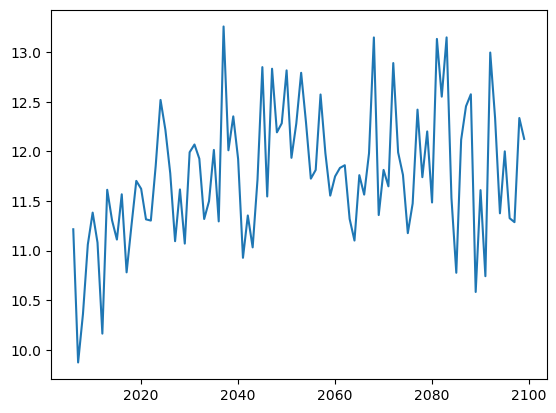

In [115]:
# example timeseries plot
fig = plt.figure()
ax = plt.axes()
ax.plot(pyrenees_ts.year, pyrenees_ts)